 
# Alpha and Beta Diversity

Different higher-level measures are often used to describe the microbiome in a sample. These do not provide information on changes in the abundance of specific taxa but allow us to access a broader change or difference in the composition of microorganisms. Alpha and beta diversity are examples of such measures.

Different measures exist to estimate diversity within a single sample, jointly called alpha diversity. The different measures reflect the richness (number) or distribution (evenness) of a microbial sample or aim to reflect a combination of both properties.

Rarefaction curves are often used when calculating alpha diversity indices because increasing numbers of sequenced taxa allow increasingly accurate estimates of total population diversity. Rarefaction curves can therefore be used to estimate the full sample richness, as compared to the observed sample richness.

While alpha diversity is a measure of microbiome diversity applicable to a single sample, beta diversity is a measure of the similarity or dissimilarity of two communities. As for alpha diversity, many indices exist, each reflecting different aspects of community heterogeneity. Key differences relate to how the indices value variation in rare species if they consider presence/absence only or incorporate abundance, and how they interpret shared absence. Bray-Curtis dissimilarity is a popular measure that considers both size (overall abundance per sample) and shape (abundance of each taxon) of the communities (Bray, 1957). Beta diversity is an essential measure for many popular statistical methods in ecology, such as ordination-based methods, and is widely used for studying the association between environmental variables and microbial composition.

In summary, alpha diversity measures can be seen as a summary statistic of a single population (within-sample diversity), while beta diversity measures are estimates of similarity or dissimilarity between populations (between samples).

**Source**: (https://biomcare.com/info/key-terms-in-microbiome-projects/)

### STEP : Diversity Analysis

Using QIIME2 to create diversity analisys graphs and calculations.

- [QIIME2 Workflow Overview](https://docs.qiime2.org/2022.8/tutorials/overview/)


#### Methods
- [diversity](https://docs.qiime2.org/2022.8/plugins/available/diversity/)
- [diversity alpha](https://docs.qiime2.org/2022.8/plugins/available/diversity/alpha/)
- [diversity alpha_phylogenetic](https://docs.qiime2.org/2022.8/plugins/available/diversity/alpha-phylogenetic/)
- [diversity beta](https://docs.qiime2.org/2022.8/plugins/available/diversity/beta/)
- [diversity core_metrics](https://docs.qiime2.org/2022.8/plugins/available/diversity/core-metrics/)
- [diversity alpha_group_significance](https://docs.qiime2.org/2022.8/plugins/available/diversity/alpha-group-significance/)
- [diversity beta_group_significance](https://docs.qiime2.org/2022.8/plugins/available/diversity/beta-group-significance/)
- [feature_table core_features](https://docs.qiime2.org/2022.8/plugins/available/feature-table/core-features/)
- [feature_table summarize](https://docs.qiime2.org/2022.8/plugins/available/feature-table/summarize/)
- [taxa filter-table](https://docs.qiime2.org/2022.8/plugins/available/taxa/filter-table/)
- [taxa collapse](https://docs.qiime2.org/2022.8/plugins/available/taxa/collapse/)

## Setup and settings

In [1]:
# Importing packages
import os
import pandas as pd
from qiime2 import Artifact
from qiime2 import Visualization
from qiime2 import Metadata

from qiime2.plugins.phylogeny.pipelines import align_to_tree_mafft_fasttree

from qiime2.plugins.diversity.pipelines import alpha
from qiime2.plugins.diversity.pipelines import beta
from qiime2.plugins.diversity.pipelines import core_metrics
from qiime2.plugins.diversity.pipelines import alpha_phylogenetic

from qiime2.plugins.diversity.visualizers import alpha_group_significance
from qiime2.plugins.diversity.visualizers import beta_group_significance
from qiime2.plugins.diversity.visualizers import alpha_correlation
from qiime2.plugins.diversity.visualizers import beta_rarefaction

from qiime2.plugins.taxa.methods import filter_table
from qiime2.plugins.taxa.methods import collapse

from qiime2.plugins.feature_table.visualizers import tabulate_seqs
from qiime2.plugins.feature_table.visualizers import summarize
from qiime2.plugins.feature_table.visualizers import core_features

from qiime2.plugins.alignment.methods import mafft


import matplotlib.pyplot as plt

from utils import *

%matplotlib inline

### Receiving the parameters

The following cell can receive parameters using the [papermill](https://papermill.readthedocs.io/en/latest/) tool.

In [2]:
metadata_file = '/home/lauro/nupeb/rede-micro/redemicro-miliane-nutri/data/raw/metadata/miliane-metadata-CxAC.tsv'
base_dir = os.path.join('/', 'home', 'lauro', 'nupeb', 'rede-micro', 'redemicro-miliane-nutri')
experiment_name = 'miliane-CxAC-trim'
class_col = 'group-id'
replace_files = False

In [3]:
experiment_folder = os.path.abspath(os.path.join(base_dir, 'experiments', experiment_name))
img_folder = os.path.abspath(os.path.join(experiment_folder, 'imgs'))

### Defining names, paths and flags

In [4]:
# QIIME2 Artifacts folder
qiime_folder = os.path.join(experiment_folder, 'qiime-artifacts')

# Input - DADA2 Artifacts
dada2_tabs_path = os.path.join(qiime_folder, 'dada2-tabs.qza')
dada2_reps_path = os.path.join(qiime_folder, 'dada2-reps.qza')
dada2_stat_path = os.path.join(qiime_folder, 'dada2-stat.qza')

# Input - Taxonaomic Artifacts
taxonomy_path = os.path.join(qiime_folder, 'metatax.qza')

# Output -Diversity Artifacts
alpha_diversity_path = os.path.join(qiime_folder, 'alpha-diversity.qza')
alpha_diversity_view_path = os.path.join(qiime_folder, 'alpha-diversity.qzv')
beta_diversity_path = os.path.join(qiime_folder, 'beta-diversity.qza')
beta_diversity_view_path = os.path.join(qiime_folder, 'beta-diversity.qzv')

dada2_tabs_view = os.path.join(qiime_folder, 'dada2-tabs.qzv')
dada2_reps_view = os.path.join(qiime_folder, 'dada2-reps.qzv')
dada2_core_view = os.path.join(qiime_folder, 'dada2-core.qzv')

# Flag - Load or create files
need_tax = not (os.path.isfile(alpha_diversity_path)) or replace_files
need_view = not (os.path.isfile(alpha_diversity_view_path)) or replace_files

In [5]:
def filter_and_collapse(tab, seqs, tax, meta, lvl, exclude=True, exclude_list='uncultured,unidentified,metagenome'):
    from qiime2.plugins.taxa.methods import collapse
    from qiime2.plugins.taxa.methods import filter_table
    from qiime2.plugins.feature_table.methods import filter_seqs
    from qiime2.plugins.feature_table.visualizers import summarize
    
    to_include = ('d', 'p', 'c', 'o', 'f', 'g', 's')[lvl-1]
    to_include += '__'
    to_exclude = exclude_list if exclude else None
    
    filtered_tabs = filter_table(
        table=tab, 
        taxonomy=tax,
        include=to_include,
        exclude=to_exclude,
        mode='contains').filtered_table
    
    filtered_seqs = filter_seqs(
        data = seqs,
        table = filtered_tabs,
    ).filtered_data
    
    collapsed_table = collapse(table=filtered_tabs, taxonomy=tax, level=lvl).collapsed_table
    collapsed_table_view = summarize(table=collapsed_table, sample_metadata=meta).visualization
    
    return collapsed_table, collapsed_table_view, filtered_seqs

## Step execution

### Load input files

This Step import the QIIME2 `FeatureTable[Frequency]` Artifact and the `Metadata` file.

In [6]:
#Load Metadata
metadata_qa = Metadata.load(metadata_file)

#Load FeatureTable[Frequency]
tabs = Artifact.load(dada2_tabs_path)
tabs_df = tabs.view(Metadata).to_dataframe().T

# FeatureData[Sequence]
reps = Artifact.load(dada2_reps_path)

# FeatureData[Taxonomy]
tax = Artifact.load(taxonomy_path)

In [7]:
# lvl = 7
# exclude = True
# tabs, collapsed_table_view, reps = filter_and_collapse(
#                     tabs, reps, tax, metadata_qa, 
#                     lvl=lvl,
#                     exclude=exclude, 
#                     exclude_list='uncultured,unidentified,metagenome')
# collapsed_table_view

'/home/lauro/nupeb/rede-micro/redemicro-miliane-nutri/experiments/miliane-CxAC-trim/qiime-artifacts/dada2-core.qzv'

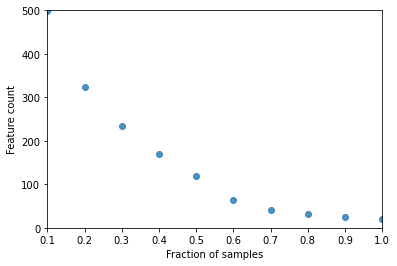

In [8]:
tabs_view = summarize(table=tabs, sample_metadata=metadata_qa).visualization
tabs_view.save(dada2_tabs_view)
reps_view = tabulate_seqs(data=reps).visualization
reps_view.save(dada2_reps_view)
core_view = core_features(table=tabs, min_fraction=.1, steps=10).visualization
core_view.save(dada2_core_view)

In [9]:
import zipfile
from io import StringIO
import pandas as pd
with zipfile.ZipFile(dada2_core_view, 'r') as zip_ref:
    names = [x for x in zip_ref.namelist() if x.endswith('1.000.tsv')]
    print(names)
    with zip_ref.open(names[0]) as myfile:
        txt = str(myfile.read(), 'utf-8')
        txt = StringIO(txt)
        df = pd.read_csv(txt, sep='\t')
        print(df)   

['6f060e2c-ee21-425e-9345-522910e77455/data/core-features-1.000.tsv']
                          Feature ID      2%       9%      25%     50%  \
0   c688e3b1ada46ed57f5b7e7e0d56664f  400.74   567.83  3168.50  9079.5   
1   fca5b1ccd94b107a3ddf3e99feaafb6f  812.32  1278.94  2834.25  5627.0   
2   26fb6a43293a39fa4463bc35a69457b2  420.58   643.11  2381.00  3918.0   
3   55b8f708d3561852ca20801e513b08a7  412.98   612.41   900.75  3566.5   
4   ff6880f38ac8c1569873d503a3d53c2a  901.16  1384.72  1836.25  3381.0   
5   bc798de4a9acd3ff7ba51c244523be14  361.44   401.48  1101.00  2853.0   
6   a1bc173c37d38b7a95f6f464d62fa86e  348.68   729.06  1012.50  1532.5   
7   60ad690613589cad95c200968df41bb5  227.00   304.00   454.25  1313.0   
8   33be3de1f8ec58c58a1d87db108d913c  453.74   736.33   924.25  1263.0   
9   bfbcddb34034c8e1327bc8e4a3817f73  445.62   731.29   847.75  1012.0   
10  94da0800673da2590ace91fc6e62c80a   91.86   101.87   377.50   809.5   
11  b6b804323b11530a7bb8c25d42de7c58  341.

## Alpha diversity analysis

#### Reference
- [The Use and Types of Alpha-Diversity Metrics in Microbial NGS](https://www.cd-genomics.com/microbioseq/the-use-and-types-of-alpha-diversity-metrics-in-microbial-ngs.html)
- [Alpha diversity metrics](http://scikit-bio.org/docs/0.2.0/generated/skbio.diversity.alpha.html)

#### Methods
- [diversity alpha](https://docs.qiime2.org/2022.8/plugins/available/diversity/alpha/): Computes a user-specified alpha diversity metric for all samples in a
feature table.
- [diversity alpha_phylogenetic](https://docs.qiime2.org/2022.8/plugins/available/diversity/alpha-phylogenetic/): Computes a user-specified phylogenetic alpha diversity metric for all
samples in a feature table.
- [diversity alpha_correlation](https://docs.qiime2.org/2022.8/plugins/available/diversity/alpha-correlation/): Determine whether numeric sample metadata columns are correlated with alpha diversity.
- [diversity alpha_group_significance](https://docs.qiime2.org/2022.8/plugins/available/diversity/alpha-group-significance/): Visually and statistically compare groups of alpha diversity values.

### Compute Alpha Diversity vectors
- [diversity alpha](https://docs.qiime2.org/2022.8/plugins/available/diversity/alpha/): Computes a user-specified alpha diversity metric for all samples in a feature table.
- [Alpha diversity metrics](http://scikit-bio.org/docs/0.2.0/generated/skbio.diversity.alpha.html)
 - Choices: ('ace', 'berger_parker_d', 'brillouin_d', 'chao1', 'chao1_ci', 'dominance', 'doubles', 'enspie', 'esty_ci', 'fisher_alpha', 'gini_index', 'goods_coverage', 'heip_e', 'kempton_taylor_q', 'lladser_pe', 'margalef', 'mcintosh_d', 'mcintosh_e', 'menhinick', 'michaelis_menten_fit', 'observed_features', 'osd', 'pielou_e', 'robbins', 'shannon', 'simpson', 'simpson_e', 'singles', 'strong')

In [10]:
metrics = ('chao1', 'simpson', 'shannon', 'ace', 'observed_features')
alpha_diversities = dict()
for metric in metrics:
    print(f"Calculating alpha diversty: {metric}")
    alpha_diversity = alpha(table=tabs, metric=metric).alpha_diversity
    alpha_diversities[metric] = alpha_diversity

Calculating alpha diversty: chao1
Calculating alpha diversty: simpson
Calculating alpha diversty: shannon
Calculating alpha diversty: ace
Calculating alpha diversty: observed_features


### Create Phylogenetic inference

- [alignment align_to_tree_mafft_fasttree](https://docs.qiime2.org/2022.8/plugins/available/phylogeny/align-to-tree-mafft-fasttree/): Build a phylogenetic tree using fasttree and mafft alignment

This pipeline will start by creating a sequence alignment using MAFFT,
after which any alignment columns that are phylogenetically uninformative
or ambiguously aligned will be removed (masked). The resulting masked
alignment will be used to infer a phylogenetic tree and then subsequently
rooted at its midpoint. Output files from each step of the pipeline will be
saved. This includes both the unmasked and masked MAFFT alignment from
q2-alignment methods, and both the rooted and unrooted phylogenies from
q2-phylogeny methods.


Returns
- alignment : FeatureData[AlignedSequence] : The aligned sequences.
- masked_alignment : FeatureData[AlignedSequence] : The masked alignment.
- tree : Phylogeny[Unrooted] : The unrooted phylogenetic tree.
- rooted_tree : Phylogeny[Rooted] : The rooted phylogenetic tree.

In [11]:
mafft_alignment, mafft_masked_alignment, mafft_tree, mafft_rooted_tree = align_to_tree_mafft_fasttree(
    sequences=reps, n_threads=6, )

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: mafft --preservecase --inputorder --thread 6 /tmp/qiime2-archive-v04ml_kj/2f80a2b8-d473-4e42-82e6-a2f605b0e0d9/data/dna-sequences.fasta



inputfile = orig
918 x 430 - 271 d
nthread = 6
nthreadpair = 6
nthreadtb = 6
ppenalty_ex = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
  901 / 918 (thread    1)
done.

Constructing a UPGMA tree (efffree=0) ... 
  910 / 918
done.

Progressive alignment 1/2... 
STEP   701 / 917 (thread    4)
Reallocating..done. *alloclen = 1868
STEP   901 / 917 (thread    5)
done.

Making a distance matrix from msa.. 
  900 / 918 (thread    5)
done.

Constructing a UPGMA tree (efffree=1) ... 
  910 / 918
done.

Progressive alignment 2/2... 
STEP   801 / 917 (thread    5)
Reallocating..done. *alloclen = 1875
STEP   901 / 917 (thread    5) h
done.

disttbfast (nuc) Version 7.490
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
6 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto in

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: FastTreeMP -quote -nt /tmp/qiime2-archive-yiu3jme4/eb5454fb-90bd-4dee-9989-8e6cf8994526/data/aligned-dna-sequences.fasta



FastTree Version 2.1.10 Double precision (No SSE3), OpenMP (6 threads)
Alignment: /tmp/qiime2-archive-yiu3jme4/eb5454fb-90bd-4dee-9989-8e6cf8994526/data/aligned-dna-sequences.fasta
Nucleotide distances: Jukes-Cantor Joins: balanced Support: SH-like 1000
Search: Normal +NNI +SPR (2 rounds range 10) +ML-NNI opt-each=1
TopHits: 1.00*sqrtN close=default refresh=0.80
ML Model: Jukes-Cantor, CAT approximation with 20 rate categories
      0.11 seconds: Joined    100 of    870
      0.23 seconds: Joined    300 of    870
      0.37 seconds: Joined    500 of    870
      0.49 seconds: Joined    700 of    870
Initial topology in 0.60 seconds
Refining topology: 39 rounds ME-NNIs, 2 rounds ME-SPRs, 20 rounds ML-NNIs
      0.60 seconds: ME NNI round 1 of 39, 1 of 871 splits
      0.70 seconds: ME NNI round 4 of 39, 401 of 871 splits, 12 changes (max delta 0.007)
      0.83 seconds: SPR round   1 of   2, 201 of 1744 nodes
      0.96 seconds: SPR round   1 of   2, 401 of 1744 nodes
      1.11 seconds

### Compute Alpha Diversity (Phylogeny)
- [diversity alpha_phylogenetic](https://docs.qiime2.org/2022.8/plugins/available/diversity/alpha-phylogenetic/): Computes a user-specified phylogenetic alpha diversity metric for all samples in a feature table.
- Metrics: Choices ('faith_pd')

In [12]:
metrics = ('faith_pd', )
alpha_diversities_phylogenetic = dict()
for metric in metrics:
    print(f"Calculating alpha diversity: {metric}")
    alpha_diversity = alpha_phylogenetic(table=tabs, phylogeny=mafft_rooted_tree, metric=metric).alpha_diversity
    alpha_diversities_phylogenetic[metric] = alpha_diversity

Calculating alpha diversity: faith_pd


### Alpha diversity correlation

This method only process `numeric` columns.


In [13]:
methods = ('spearman', 'pearson')
numerics_cols = metadata_qa.filter_columns(column_type='numeric')
if numerics_cols.column_count > 0:
    for metric, alpha_values in alpha_diversities.items():
        for method in methods:
            corr_view = alpha_correlation(alpha_diversity=alpha_values, metadata=numerics_cols, 
                                      method=method, intersect_ids=True).visualization
            view_path = os.path.join(qiime_folder, f'alpha-correlation-{metric}-{method}.qzv')
            corr_view.save(view_path)
            corr_view

## Alpha diversity comparisons

Visually and statistically compare groups of alpha diversity values.

[diversity alpha_group_significance](https://docs.qiime2.org/2022.8/plugins/available/diversity/alpha-group-significance/)

In [14]:
for metric, alpha_values in alpha_diversities.items():
    print(f"Processing alpha_group_significance: {metric}")
    significance_view = alpha_group_significance(alpha_diversity=alpha_values, metadata=metadata_qa).visualization
    view_path = os.path.join(qiime_folder, f'alpha-group-significance-{metric}.qzv')
    significance_view.save(view_path)
    significance_view

Processing alpha_group_significance: chao1
Processing alpha_group_significance: simpson
Processing alpha_group_significance: shannon
Processing alpha_group_significance: ace
Processing alpha_group_significance: observed_features


## Beta diversity analysis

#### Reference
- [diversity beta](https://docs.qiime2.org/2022.8/plugins/available/diversity/beta/): Computes a user-specified beta diversity metric for all pairs of samples in a feature table.
- [Beta diversity metrics](http://scikit-bio.org/docs/0.2.0/generated/skbio.diversity.beta.html)

- Metric Choices('aitchison', 'braycurtis', 'canberra', 'canberra_adkins', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'jensenshannon', 'kulsinski', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule')

In [15]:
metrics = ('dice', 'braycurtis', 'chebyshev', 'jaccard')
beta_diversities = dict()
for metric in metrics:
    print(f"Calculating beta diversity: {metric}")
    beta_diversity = beta(table=tabs, metric=metric, n_jobs=6, pseudocount=1).distance_matrix
    beta_diversities[metric] = beta_diversity

Calculating beta diversity: dice
Calculating beta diversity: braycurtis
Calculating beta diversity: chebyshev
Calculating beta diversity: jaccard


/home/lauro/anaconda3/envs/qiime2-2022.2/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1761: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/home/lauro/anaconda3/envs/qiime2-2022.2/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1761: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


### Beta group significance

- [diversity beta_group_significance](https://docs.qiime2.org/2022.8/plugins/available/diversity/beta-group-significance/): Determine whether groups of samples are significantly different from one another using a permutation-based statistical test.
- Marti J Anderson. A new method for non-parametric multivariate analysis of variance. Austral ecology, 26(1):32–46, 2001. doi:https://doi.org/10.1111/j.1442-9993.2001.01070.pp.x.

In [16]:
methods = ('permanova', 'anosim', 'permdisp')
for method in methods:
    for metric, beta_diversity in beta_diversities.items():
        print(f'Calculating beta group significance with method {method} and metric {metric}')
        beta_view = beta_group_significance(distance_matrix=beta_diversity, 
                                            metadata=metadata_qa.get_column('group-id'), 
                                            pairwise=True, method=method).visualization
        view_name = os.path.join(qiime_folder, f'beta-group-significance-{metric}-{method}.qzv')
        beta_view.save(view_name)

Calculating beta group significance with method permanova and metric dice
Calculating beta group significance with method permanova and metric braycurtis
Calculating beta group significance with method permanova and metric chebyshev
Calculating beta group significance with method permanova and metric jaccard
Calculating beta group significance with method anosim and metric dice
Calculating beta group significance with method anosim and metric braycurtis
Calculating beta group significance with method anosim and metric chebyshev
Calculating beta group significance with method anosim and metric jaccard
Calculating beta group significance with method permdisp and metric dice
Calculating beta group significance with method permdisp and metric braycurtis
Calculating beta group significance with method permdisp and metric chebyshev


/home/lauro/anaconda3/envs/qiime2-2022.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -95033973.72889368 and the largest is 1022480902.9013429.
  warn(
/home/lauro/anaconda3/envs/qiime2-2022.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more 

Calculating beta group significance with method permdisp and metric jaccard


<Figure size 432x288 with 0 Axes>

### Beta group Rarefaction

- [diversity beta_rarefaction](https://docs.qiime2.org/2022.8/plugins/available/diversity/beta-rarefaction/): Repeatedly rarefy a feature table to compare beta diversity results within a given rarefaction depth.  For a given beta diversity metric, this visualizer will provide: an Emperor jackknifed PCoA plot, samples clustered by UPGMA or neighbor joining with support calculation, and a heatmap showing the correlation between rarefaction trials of that beta diversity metric.